# Propósito

- Criar um modelo preditivo que saiba diferenciar uma imagem dos seguintes itens : Mão humana, mamão, abacate. 

## Caracterização do dado

Para isto, serão baixadas imagens buscadas pelo duck duck go.
Em seguida serão salvas nas pastas: [dataset/hand](dataset/hand),
[dataset/papaya](dataset/papaya), [dataset/avocado](dataset/avocado).
As imagens baixadas podem possuir largura de no máximo 400px, entretanto para sua 
análise será utilizado o método **crop** para obter imagens de 192px por 192px.

# Testando busca de imagnes

In [14]:
#hide
!pip install -Uqq fastbook
!pip install -Uqq duckduckgo_search
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

In [8]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [18]:
urls = search_images('hand', max_images=1)
urls[0]

'https://upload.wikimedia.org/wikipedia/commons/b/bf/Left_Hand_-_Kolkata_2011-04-20_2350.JPG'

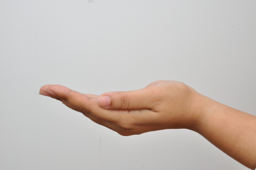

In [19]:
from fastdownload import download_url
dest = 'hand.' + urls[0][-3:]
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

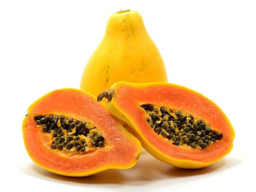

In [20]:
download_url(search_images('papaya', max_images=1)[0], 'papaya.png', show_progress=False)
Image.open('papaya.png').to_thumb(256,256)

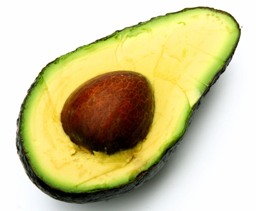

In [51]:
download_url(search_images('avocado', max_images=1)[0], 'avocado.png', show_progress=False)
Image.open('avocado.png').to_thumb(256,256)

In [42]:
## Os códigos a cima geraram duas imagens na pasta atual, esta célula apaga estas imagens. No final do notebook elas serão utilizadas para testar o código.
!rm *.jpg *.png *.jpeg

rm: cannot remove '*.jpg': No such file or directory


# Buscando e baixando imagens do dataset

In [ ]:
from time import sleep

# Cada elemento de busca é uma tupla que possui um nome para o dataset e uma chave de busca.
searches = [('papaya','papaya fruit'),('hand','human hand'), ('avocado', 'avocado fruit')]
images_per_search = 60

path = Path('dataset')

for element in searches:
    dest = (path/element[0])
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{element[1]}', images_per_search))

    resize_images(path/element[0], max_size=400, dest=path/element[0])

In [45]:
# Código para limpar o dataset, caso necessário.
!rm -rf dataset/*

In [52]:
# Buscando por imagens que deram erro durante o download e removendo-as
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

# Treinando o modelo

## Assinatura do DataBlock  

In [33]:
?DataBlock

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`.
File:           /opt/conda/lib/python3.10/site-packages/fastai/data/block.py
Type:           type
Subclasses:     

## Assinatura da classe Resize

In [43]:
?Resize

Init signature:
Resize(
    self,
    size: 'int | tuple',
    method: 'ResizeMethod' = 'crop',
    pad_mode: 'PadMode' = 'reflection',
    resamples=(<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>),
    **kwargs,
)
Docstring:      A transform that before_call its state at each `__call__`
File:           /opt/conda/lib/python3.10/site-packages/fastai/vision/augment.py
Type:           _TfmMeta
Subclasses:     

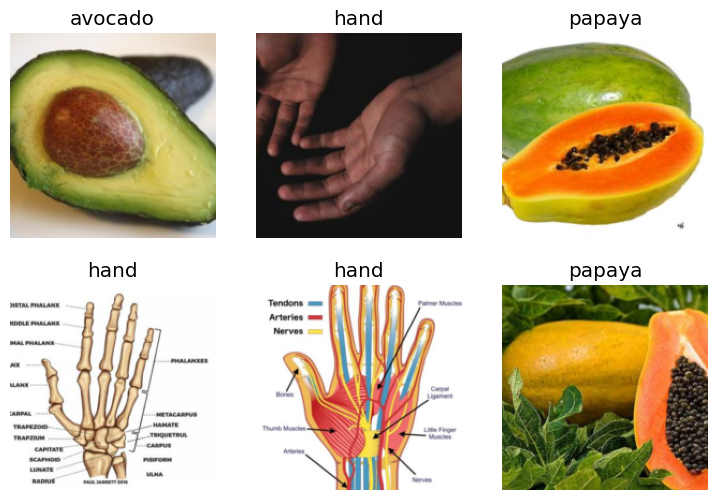

In [54]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [55]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.372061,0.200766,0.074074,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.207552,0.044849,0.000000,00:44
1,0.139058,0.011587,0.000000,00:43
2,0.100932,0.007164,0.000000,00:38


# Análise das imagens baixadas


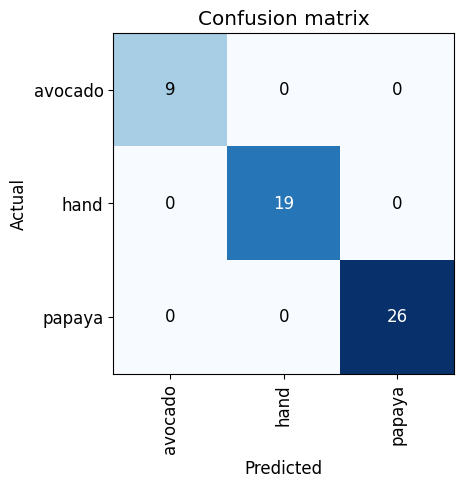

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Testando o modelo

## A mão é uma mão ?

In [60]:
this_is ,_,probs = learn.predict(PILImage.create('hand.JPG'))
print(f"This is a: {this_is}.")
print(f"Probability it's hand: {probs[1]:.4f}")

This is a: hand.
Probability it's hand: 0.9548


## O mamão é um mamão ?

In [63]:
this_is ,_,probs = learn.predict(PILImage.create('papaya.png'))
print(f"This is a: {this_is}.")
print(f"Probability it's papaya: {probs[2]:.4f}")

This is a: papaya.
Probability it's papaya: 0.9981


## O abacate é um abacate ?

In [62]:
this_is ,_,probs = learn.predict(PILImage.create('avocado.png'))
print(f"This is a: {this_is}.")
print(f"Probability it's avocado: {probs[0]:.4f}")

This is a: avocado.
Probability it's avocado: 1.0000


In [73]:
learn.export('model.pkl')

## Link para o deploy no HuggingFace

[Deploy is here.](https://huggingface.co/spaces/HellSank/papaya?logs=build)